# Bollinger Bands Strategy and Backtesting

Prepared by Samalie Piwan   
Email : spiwan@andrew.cmu.edu

Load the libraries to be used in the project

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
import os
import csv
import backtesting
from datetime import datetime, timedelta
from dateutil import parser
from backtesting import Backtest, Strategy
from tabulate import tabulate
from backtesting.lib import crossover, cross, TrailingStrategy
import unittest
backtesting.set_bokeh_output(notebook=False)

## 1.Strategy Setup

This analysis focused on testing the robustness of five trading strategies. In this study, we aim to objectively evaluate the performance of these strategies across various market conditions. As the financial landscape shifts, understanding the reliability and effectiveness of different trading approaches is crucial for traders seeking to navigate markets successfully. The strategies below have been considered for robustness tests.

1.Bollinger Bands

2.Relative Strength Index (RSI)

3.Moving Average Convergence Divergence (MACD)

4.Simple Moving Average Crossover Strategy

5.Stochastic Oscillator

### 1.1 Loading API data

Calculate the date ranges that will be used to load and slice the data

In [128]:
today = datetime.today().strftime('%Y-%m-%d')

In [129]:
last_729_days = (datetime.now() - timedelta(days = 729)).date()
last_729_days_date = last_729_days.strftime('%Y-%m-%d')

In [130]:
next_365_days = (last_729_days + timedelta(days = 365))
next_365_days_date = next_365_days.strftime('%Y-%m-%d')

In [131]:
next_366_days = (next_365_days + timedelta(days = 1))
next_366_days_date = next_366_days.strftime('%Y-%m-%d')

In [132]:
slice_one_end_date = next_365_days_date
slice_two_start_date = next_366_days_date

First, we set the initial parameters for loading the data. We also load the hourly data from the **Yahoo Finance** API.<br>
Because we cannot load data past 730 days from the API, we will load data from 20th October 2021 to 20th October 2023

In [133]:
forex_pair = "EURUSD=X"
interval = "1h"
start_date = last_729_days_date
end_date = today

In [134]:
price_data = yf.download(forex_pair, interval = interval, start = start_date)

[*********************100%%**********************]  1 of 1 completed


Next, we split the data into two datasets **insample_data** and **outsample_data**.
  - insample_data will contain data for one year, starting two years ago
  - outsample_data will contain data for one year, starting one years ago

In [135]:
insample_data = pd.DataFrame(price_data.loc[last_729_days_date : slice_one_end_date].copy())
outsample_data = pd.DataFrame(price_data.loc[slice_two_start_date:today].copy())

### 1.2 Startegy setup with Pandas TA library

Set the global plot style

In [136]:
plt.style.use('ggplot')

**a) Bollinger Bands**

Create variables for the initial EMA window and Standard Deviation

In [137]:
init_ema_window = 60
init_std = 2

In [138]:
bb_plot_insample_df = insample_data.copy()
bbands = bb_plot_insample_df.ta.bbands(close = 'Close', length = init_ema_window,
                              std = init_std, mamode="ema", append=True)
bb_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,BBL_60_2.0,BBM_60_2.0,BBU_60_2.0,BBB_60_2.0,BBP_60_2.0
Datetime,,,,,,,,,,,
2022-12-02 18:00:00+00:00,1.052853,1.053519,1.052189,1.052189,1.052189,0,1.033763,1.047213,1.060662,2.568587,0.684988
2022-12-02 19:00:00+00:00,1.052078,1.053852,1.051304,1.053741,1.053741,0,1.034112,1.047427,1.060742,2.542395,0.737107
2022-12-02 20:00:00+00:00,1.053630,1.054185,1.053408,1.053630,1.053630,0,1.034395,1.047630,1.060865,2.526733,0.726654
2022-12-02 21:00:00+00:00,1.053741,1.054519,1.053741,1.054407,1.054407,0,1.034741,1.047852,1.060964,2.502527,0.749978
2022-12-02 22:00:00+00:00,1.053075,1.053075,1.053075,1.053075,1.053075,0,1.035130,1.048023,1.060917,2.460532,0.695893


Plot the Bollinger Bands

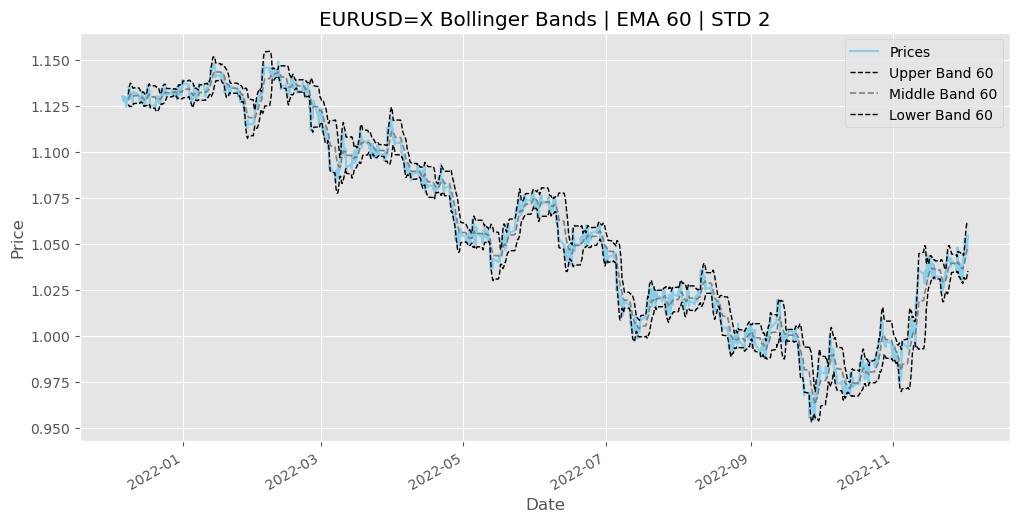

In [139]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_upper_band = f"BBU_{init_ema_window}_{init_std}.0"
str_middle_band = f"BBM_{init_ema_window}_{init_std}.0"
str_lower_band = f"BBL_{init_ema_window}_{init_std}.0"

# Plot the Bollinger Bands
plt.figure(figsize = (12,6))
plt.title(forex_pair+" Bollinger Bands | EMA "+str(init_ema_window)+" | STD "+str(init_std))
bb_plot_insample_df['Close'].plot(label = 'Prices', color = 'skyblue')
bb_plot_insample_df[str_upper_band].plot(
    label = 'Upper Band '+str(init_ema_window), 
    linestyle = '--', 
    linewidth = 1, 
    color = 'black')
bb_plot_insample_df[str_middle_band].plot(
    label = 'Middle Band '+str(init_ema_window),
    linestyle = '--',
    linewidth = 1.2,
    color = 'grey')
bb_plot_insample_df[str_lower_band].plot(
    label = 'Lower Band '+str(init_ema_window), 
    linestyle = '--', 
    linewidth = 1, 
    color = 'black')
plt.fill_between(
    bb_plot_insample_df.index,
    bb_plot_insample_df[str_lower_band],
    bb_plot_insample_df[str_upper_band],
    color='grey',
    alpha = 0.05)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**b) Relative Strength Index (RSI)**

Create variables for the initial length

In [140]:
init_rsi_len = 14
init_rsi_scalar = 100

In [141]:
rsi_plot_insample_df = insample_data.copy()
rsi_plot_insample_df.ta.rsi(close = 'Close', length = init_rsi_len, scalar = init_rsi_scalar, append = True)
rsi_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI_14
Datetime,,,,,,,
2022-12-02 18:00:00+00:00,1.052853,1.053519,1.052189,1.052189,1.052189,0,54.689702
2022-12-02 19:00:00+00:00,1.052078,1.053852,1.051304,1.053741,1.053741,0,58.435839
2022-12-02 20:00:00+00:00,1.053630,1.054185,1.053408,1.053630,1.053630,0,58.066181
2022-12-02 21:00:00+00:00,1.053741,1.054519,1.053741,1.054407,1.054407,0,59.976552
2022-12-02 22:00:00+00:00,1.053075,1.053075,1.053075,1.053075,1.053075,0,55.325600


Plot the RSI graph

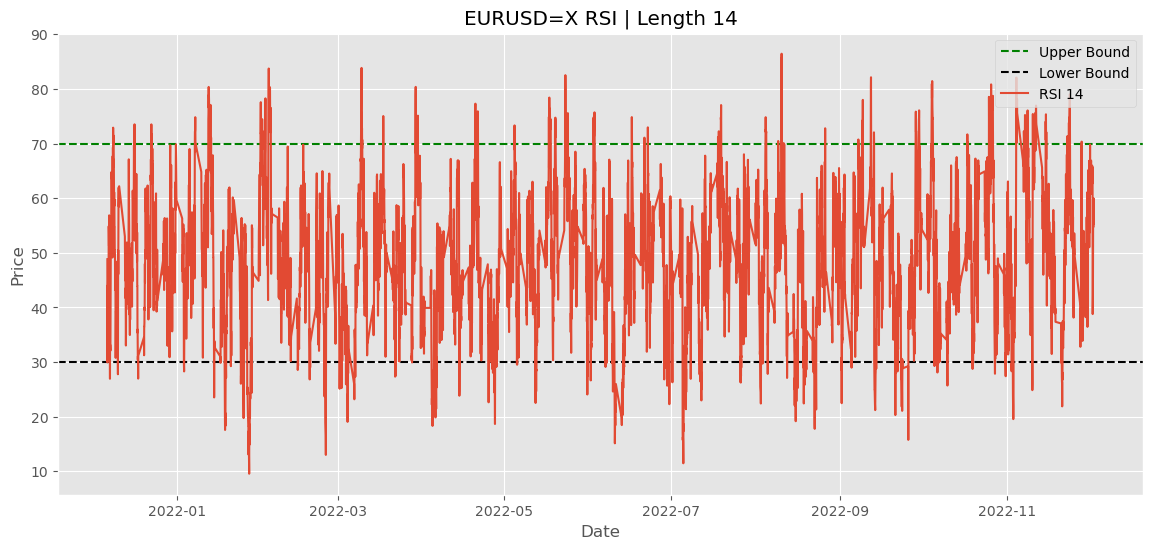

In [142]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_rsi_col = f"RSI_{init_rsi_len}"
rsi_max = rsi_plot_insample_df[str_rsi_col].max()

# Plot the Bollinger Bands
plt.figure(figsize = (14,6))
plt.title(forex_pair+" RSI | Length "+str(init_rsi_len))
plt.axhline(y=70, linestyle='dashed', xmin = 0, xmax = rsi_max, color='green', label='Upper Bound')
plt.axhline(y=30, linestyle='dashed', xmin = 0, xmax = rsi_max, color='black', label='Lower Bound')
plt.plot(rsi_plot_insample_df[str_rsi_col], label = 'RSI '+str(init_rsi_len))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**c) Moving Average Convergence Divergence (MACD)**

Create variables for the initial fast, slow and signal values

In [143]:
init_fast = 12
init_slow = 25
init_signal = 5

In [144]:
macd_plot_insample_df = insample_data.copy()
macd_plot_insample_df.ta.macd(close = 'Close', fast = init_fast, slow = init_slow, signal = init_signal, append = True)
macd_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,MACD_12_25_5,MACDh_12_25_5,MACDs_12_25_5
Datetime,,,,,,,,,
2022-12-02 18:00:00+00:00,1.052853,1.053519,1.052189,1.052189,1.052189,0,0.000683,-0.000108,0.000791
2022-12-02 19:00:00+00:00,1.052078,1.053852,1.051304,1.053741,1.053741,0,0.000807,0.000010,0.000796
2022-12-02 20:00:00+00:00,1.053630,1.054185,1.053408,1.053630,1.053630,0,0.000885,0.000059,0.000826
2022-12-02 21:00:00+00:00,1.053741,1.054519,1.053741,1.054407,1.054407,0,0.000996,0.000113,0.000883
2022-12-02 22:00:00+00:00,1.053075,1.053075,1.053075,1.053075,1.053075,0,0.000968,0.000057,0.000911


In [145]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_macd = f"MACD_{init_fast}_{init_slow}_{init_signal}"
str_macd_h = f"MACDh_{init_fast}_{init_slow}_{init_signal}"
str_macd_s = f"MACDs_{init_fast}_{init_slow}_{init_signal}"

Plot the MACD graph

C:\Users\Sama\AppData\Local\Temp\ipykernel_8588\2829633288.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


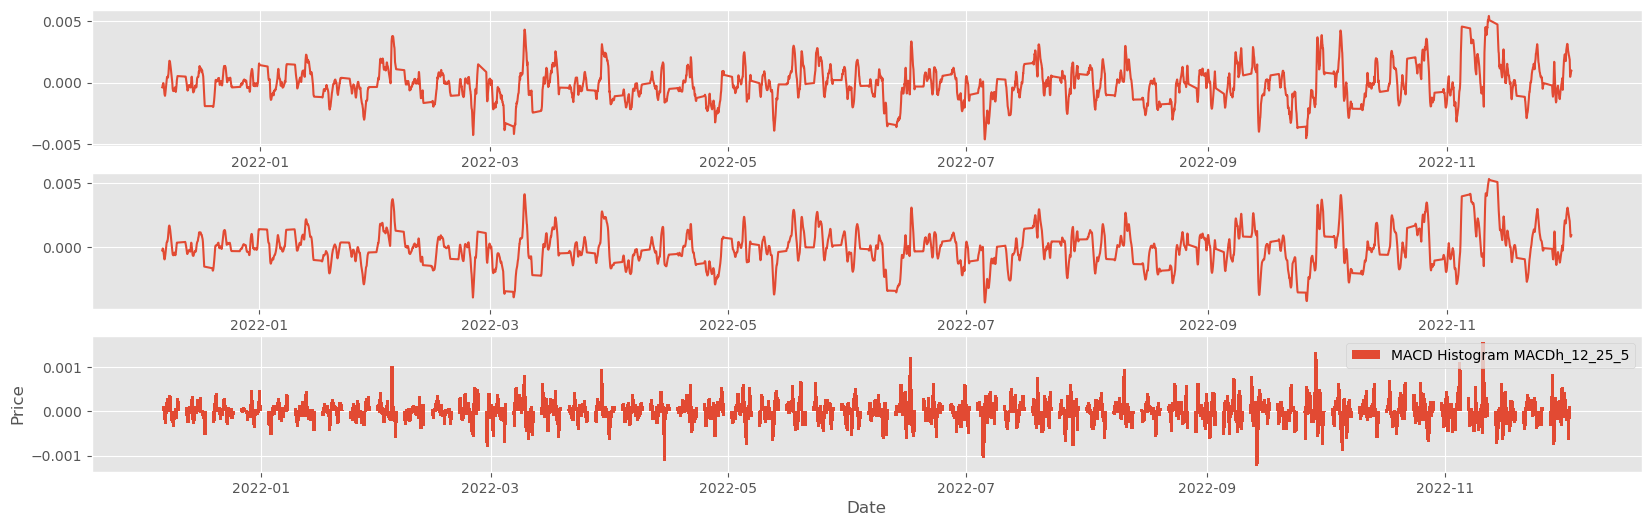

In [146]:
# Plot the Bollinger Bands
plt.figure(figsize = (20,6))
plt.title(f"{forex_pair} MACD | Fast {init_fast} | Slow {init_slow} | Signal {init_signal}")
plt.subplot(3,1,1)
plt.plot(macd_plot_insample_df[str_macd], label = 'MACD Average'+str(str_macd))
plt.subplot(3,1,2)
plt.plot(macd_plot_insample_df[str_macd_s], label = 'MACD Signal '+str(str_macd_s))
plt.subplot(3,1,3)
plt.bar(macd_plot_insample_df.index, macd_plot_insample_df[str_macd_h],
        label = 'MACD Histogram '+str(str_macd_h))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**d) Simple Moving Average Crossover Strategy**

Create variables for the initial length and offset

In [147]:
init_sma_short = 30
init_sma_long = 100

In [148]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_sma_short_col = f"SMA_{init_sma_short}"
str_sma_long_col = f"SMA_{init_sma_long}"

In [149]:
sma_plot_insample_df = insample_data.copy()
sma_plot_insample_df[str_sma_short_col] = ta.sma(sma_plot_insample_df["Close"], length=init_sma_short)
sma_plot_insample_df[str_sma_long_col] = ta.sma(sma_plot_insample_df["Close"], length=init_sma_long)
sma_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_100
Datetime,,,,,,,,
2022-12-02 18:00:00+00:00,1.052853,1.053519,1.052189,1.052189,1.052189,0,1.051742,1.041837
2022-12-02 19:00:00+00:00,1.052078,1.053852,1.051304,1.053741,1.053741,0,1.051890,1.041975
2022-12-02 20:00:00+00:00,1.053630,1.054185,1.053408,1.053630,1.053630,0,1.051927,1.042123
2022-12-02 21:00:00+00:00,1.053741,1.054519,1.053741,1.054407,1.054407,0,1.052107,1.042292
2022-12-02 22:00:00+00:00,1.053075,1.053075,1.053075,1.053075,1.053075,0,1.052210,1.042456


Plot the SMA graph

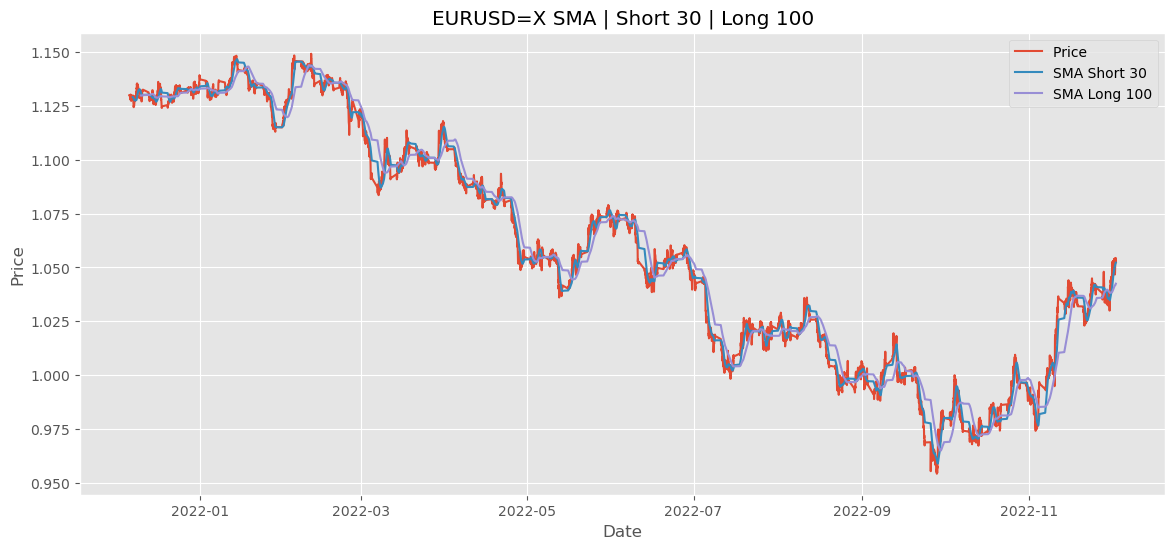

In [150]:
# Plot the charts
plt.figure(figsize = (14,6))
plt.title(forex_pair+" SMA | Short "+str(init_sma_short) + " | Long "+str(init_sma_long))
plt.plot(sma_plot_insample_df['Close'], label = 'Price ')
plt.plot(sma_plot_insample_df[str_sma_short_col], label = 'SMA Short '+str(init_sma_short))
plt.plot(sma_plot_insample_df[str_sma_long_col], label = 'SMA Long '+str(init_sma_long))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

**e) Stochastic Oscillator**

Create variables for the fast period, slow period, slow %D period and offset

In [151]:
init_stoch_fast = 1
init_stoch_slow = 3
init_stoch_smooth = 3
init_stoch_offset = 0

In [152]:
stoch_plot_insample_df = insample_data.copy()
stoch_plot_insample_df.ta.stoch(high = 'High', low='Low', close = 'Close', 
                                k = init_stoch_fast, d = init_stoch_slow, 
                                smooth_k = init_stoch_smooth, offset = init_stoch_offset,
                                append = True)
stoch_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,STOCHk_1_3_3,STOCHd_1_3_3
Datetime,,,,,,,,
2022-12-02 18:00:00+00:00,1.052853,1.053519,1.052189,1.052189,1.052189,0,51.670697,68.966605
2022-12-02 19:00:00+00:00,1.052078,1.053852,1.051304,1.053741,1.053741,0,50.915536,60.303224
2022-12-02 20:00:00+00:00,1.053630,1.054185,1.053408,1.053630,1.053630,0,41.397958,47.994730
2022-12-02 21:00:00+00:00,1.053741,1.054519,1.053741,1.054407,1.054407,0,69.965007,54.092834
2022-12-02 22:00:00+00:00,1.053075,1.053075,1.053075,1.053075,1.053075,0,38.085017,49.815994


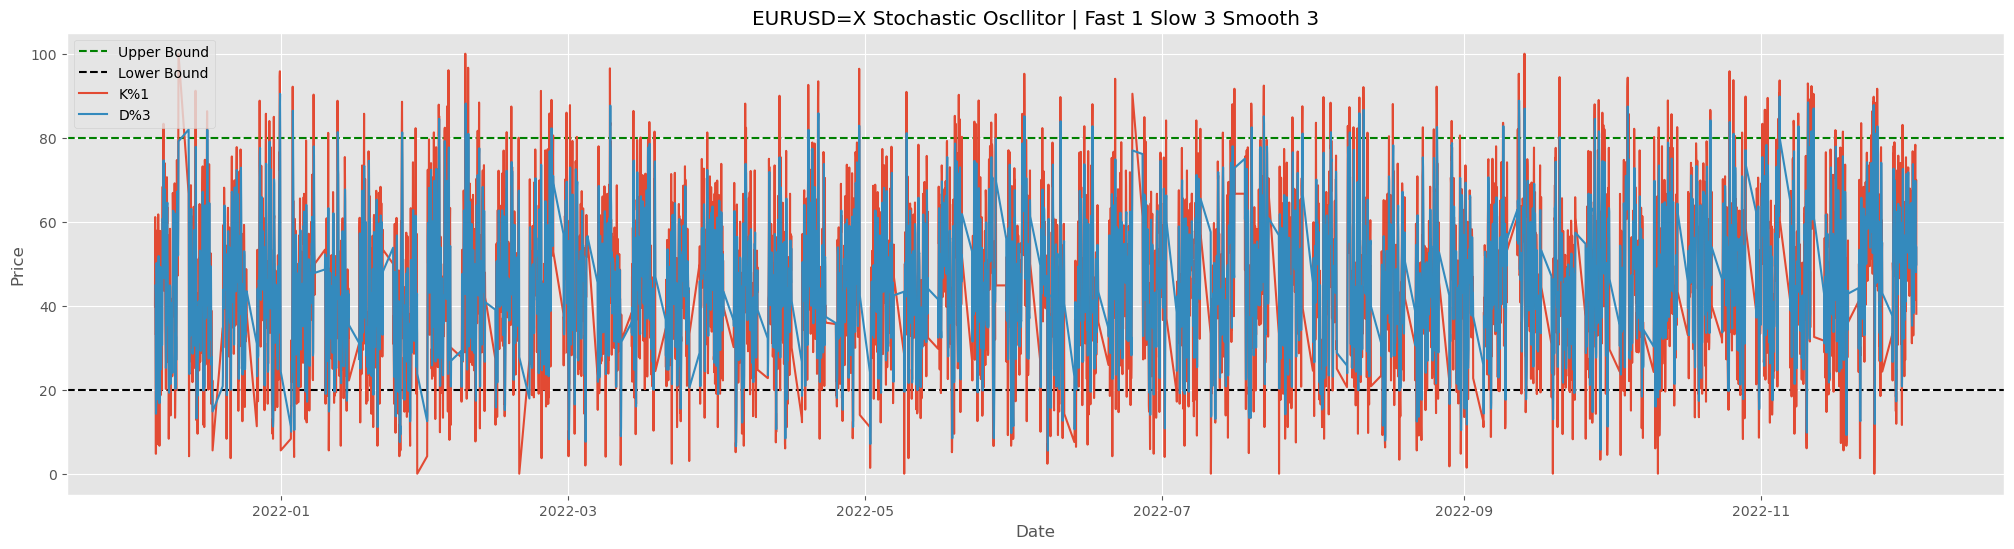

In [153]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_stoch_k_col = f"STOCHk_{init_stoch_fast}_{init_stoch_slow}_{init_stoch_smooth}"
str_stoch_d_col = f"STOCHd_{init_stoch_fast}_{init_stoch_slow}_{init_stoch_smooth}"

# Plot the charts
plt.figure(figsize = (25,6))
plt.title(forex_pair+" Stochastic Oscllitor | Fast "+str(init_stoch_fast)+
          " Slow "+str(init_stoch_slow)+
          " Smooth "+str(init_stoch_smooth))
plt.axhline(y=80, linestyle='dashed', xmin = 0, xmax = rsi_max, color='green', label='Upper Bound')
plt.axhline(y=20, linestyle='dashed', xmin = 0, xmax = rsi_max, color='black', label='Lower Bound')
plt.plot(stoch_plot_insample_df[str_stoch_k_col], label = 'K%'+str(init_stoch_fast))
plt.plot(stoch_plot_insample_df[str_stoch_d_col], label = 'D%'+str(init_stoch_slow))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### Backtest Setup

#### Strategy Setup

Define the Bollinger Bands Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [154]:
def bands_indicator(data, window, std_dev):
    
    """

    Defines the indicator that will be used by the backtesting.py Strategy class.
    Uses the pandas ta library to create and return Bollinger Bands to the Strategy class.

    Parameters
    ----------
    data : Dataframe
        The Dataframe containing the closing prices that the Bollinger Bands will be created for
    window : int
        The exponential moving average window to use when calculating the exponential moving average of the closing prices
    std_dev : float
        The standard deviation that indicates the level above and below the the simple moving average of the closing price

    Returns
    -------
    series
        The Bollinger Bands upper, middle and lower bands as a numpy series

    """
    
    bbands = ta.bbands(close = data.Close.s, length = window, std = std_dev, mamode="ema")
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
    
    """

    Extends from the backtesting.py Strategy Class to create the Bollinger Bands indicator and define the sell and buy rules
    
    Attributes
    ----------
    ema_window : float
        The exponential moving average window to use when calculating the exponential moving average of the closing prcies
    std : float
        The standard deviation that indicates the level above and below the the simple moving average of the closing price
        
    Methods
    -------
    init()
        Creates Bollinger Bands using the indicator() function defined above
        
    next()
        Define the trading logic for the strategy


    """
    
    ema_window = 0
    std = 0
        
    def init(self):
        """
            Creates Bollinger Bands using the bbands_indicator() function defined

            Returns
            -------
            series
                The Bollinger Bands upper, middle and lower bands as a numpy series
        """
        
        self.bbands = self.I(bands_indicator, self.data, self.ema_window, self.std)
        
    def next(self):
        """
            Define the trading logic for the strategy. If the closing price crosses above the upper Bollinger Band, 
            close the trade. If the closing price crosses below the lower Bollinger band, place a new long order using
            the backtesting.py buy() function

            Returns
            -------
            None
        """
        
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if crossover(lower_band, self.data.Close):
            self.position.close()
            self.buy()

        elif crossover(self.data.Close, upper_band):
            self.position.close()
            self.sell()

Define the RSI Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [155]:
def rsi_indicator(data, length, scalar):
    """
    Defines the indicator that will be used by the backtesting.py Strategy class.
    Uses the pandas ta library to create and return Relative Strength Index (RSI) to the Strategy class.

    Parameters
    ----------
    data : Dataframe
        The Dataframe containing the closing prices for which RSI will be calculated.
    length : int
        The window of days to use when calculating the Relative Strength Index.
    scalar : int
        The scale by which to magnify the Relative Strength Index.

    Returns
    -------
    series
        The RSI values as a numpy series.
    """
    
    rsi = ta.rsi(close=data.Close.s, length=length, scalar=scalar)
    return rsi.to_numpy()

class RSIStrategy(Strategy):
    """
    Extends from the backtesting.py Strategy Class to create the RSI indicator and define the sell and buy rules.

    Attributes
    ----------
    rsi_length : int
        The window of days to use when calculating the Relative Strength Index.
    rsi_scalar : int
        The scale by which to magnify the Relative Strength Index.

    Methods
    -------
    init()
        Creates the Relative Strength Index using the rsi_indicator() function defined above.
        
    next()
        Define the trading logic for the strategy.
        If the RSI crosses below the lower threshold, close the trade and place a new long order.
        If the RSI crosses above the upper threshold, close the trade and place a new short order.
    """
    
    rsi_length = 14
    rsi_scalar = 100
        
    def init(self):
        """
        Creates Relative Strength Index using the rsi_indicator() function defined.

        Returns
        -------
        series
            The Relative Strength Index numpy series.
        """
        
        self.rsi = self.I(rsi_indicator, self.data, self.rsi_length, self.rsi_scalar)
        
    def next(self):
        """
        Define the trading logic for the strategy.
        If the RSI crosses below the lower threshold, close the trade and place a new long order.
        If the RSI crosses above the upper threshold, close the trade and place a new short order.

        Returns
        -------
        None
        """
        
        rsi = self.rsi
        rsi_lower = 30
        rsi_upper = 70
        
        if crossover(rsi, rsi_lower):
            self.position.close()
            self.buy()

        elif crossover(rsi_upper, rsi):
            self.position.close()
            self.sell()

Define the Moving Average Convergence Divergence (MACD) Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [156]:
def macd_indicator(data, fast, slow, signal):
    """
    Defines the indicator that will be used by the backtesting.py Strategy class.
    Uses the pandas ta library to create and return MACD (Moving Average Convergence Divergence) for the Strategy class.

    Parameters
    ----------
    data : Dataframe
        The Dataframe containing the closing prices for which MACD will be calculated.
    fast : int
        The window of days for the fast exponential moving average in MACD calculation.
    slow : int
        The window of days for the slow exponential moving average in MACD calculation.
    signal : int
        The window of days for the signal line in MACD calculation.

    Returns
    -------
    series
        The MACD line, signal line, and histogram values as a numpy series.
    """
    
    macd = ta.macd(close=data.Close.s, fast=fast, slow=slow, signal=signal)
    return macd.to_numpy().T[:3]

class MACDStrategy(Strategy):
    """
    Extends from the backtesting.py Strategy Class to create the MACD indicator and define the sell and buy rules.

    Attributes
    ----------
    macd_fast : int
        The window of days for the fast exponential moving average in MACD calculation.
    macd_slow : int
        The window of days for the slow exponential moving average in MACD calculation.
    macd_signal : int
        The window of days for the signal line in MACD calculation.

    Methods
    -------
    init()
        Creates the MACD using the macd_indicator() function defined above.
        
    next()
        Define the trading logic for the strategy.
        If the MACD line crosses above the signal line, close the trade and place a new long order.
        If the MACD line crosses below the signal line, close the trade and place a new short order.
    """
    
    macd_fast = 0
    macd_slow = 0
    macd_signal = 0
        
    def init(self):
        """
        Creates MACD using the macd_indicator() function defined.

        Returns
        -------
        series
            The MACD fast, slow, and signal numpy series.
        """
        
        self.macd = self.I(macd_indicator, self.data, self.macd_fast, self.macd_slow, self.macd_signal)
        
    def next(self):
        """
        Define the trading logic for the strategy.
        If the MACD line crosses above the signal line, close the trade and place a new long order
        If the MACD line crosses below the signal line, close the trade and place a new short order

        Returns
        -------
        None
        """
    
        macd_line = self.macd[0]
        signal_line = self.macd[2]
                
        if crossover(macd_line, signal_line):
            self.position.close()
            self.buy()

        elif crossover(signal_line, macd_line):
            self.position.close()
            self.sell()

Define the Simple Moving Average Crossover Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [157]:
def sma_indicator(data, window_short, window_long):
    
    """
        Defines the indicator that will be used by the backtesting.py Strategy class.
        Uses the pandas ta library to create and return SMA (Simple Moving Average) the Strategy class.

        Parameters
        ----------
        data : Dataframe
            The Dataframe containing the closing prices for which SMA will be calculated.
        window : int
            The window of days for the Simple Moving Average

        Returns
        -------
        series
            The Simple Moving Average as a numpy series.
    """
    
    sma_short = ta.sma(data.Close.s, length = window_short)
    sma_long = ta.sma(data.Close.s, length = window_long)
    return np.array(list(zip(sma_short, sma_long)))

class SMAStrategy(Strategy):
    
    """
        Extends from the backtesting.py Strategy Class to create the SMA indicator and define the sell and buy rules.

        Attributes
        ----------
        short : int
            The window of days for the short-term Simple Moving Average.
        long : int
            The window of days for the long-term Simple Moving Average.

        Methods
        -------
        init()
            Creates the SMA using the sma_indicator() function defined above.

        next()
            Define the trading logic for the strategy.
            If the long SMA crosses above the short SMA, close the trade and place a new short order
            If the short SMA crosses above the long SMA, close the trade and place a new long order
    """
    
    short = 0
    long = 0
        
    def init(self):
        """
            Creates SMA using the sma_indicator() function defined

            Returns
            -------
            series
                The SMA series
        """
        
        self.sma = self.I(sma_indicator, self.data, self.short, self.long)
        
    def next(self):
        """
            Define the trading logic for the strategy based on SMA (Simple Moving Average). 
            If the close price crosses above the long-term SMA, close the trade and place a new short order.
            If the close price crosses below the long-term SMA, close the trade and place a new long order.

            Returns
            -------
            None
        """
    
        sma_short = self.sma[0]
        sma_long = self.sma[1]

        if crossover(sma_short, sma_long):
            self.position.close()
            self.buy()

        elif crossover(sma_long, sma_short):
            self.position.close()
            self.sell()

Define the Stochastic Oscillator Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [158]:
def stoch_indicator(data, stoch_fast, stoch_slow, stoch_smooth, stoch_offset):

    """
        Defines the indicator that will be used by the backtesting.py Strategy class.
        Uses the pandas ta library to create and return Stochastic Oscillator to the Strategy class.

        Parameters
        ----------
        data : Dataframe
            The Dataframe containing the closing prices for which MACD will be calculated.
        fast : int
            The fast %d period
        slow : int
            The slow %d period
        smooth:
            The Slow %D period
        offset:
            How many periods to offset the result

        Returns
        -------
        series
            The Stochastic Oscillator %k and %d as a numpy series.
    """
    
    stoch = ta.stoch(high = data.High.s, low=data.Low.s, close = data.Close.s, 
                                k = stoch_fast, d = stoch_slow, 
                                smooth_k = stoch_smooth, offset = 0)
    return stoch.to_numpy().T[:2]

class StochStrategy(Strategy):

    """

        Extends from the backtesting.py Strategy Class to create the Stochastic Oscillator
        indicator and define the sell and buy rules

        Attributes
        ----------
        fast : int
            The fast %d period
        slow : int
            The slow %d period
        smooth:
            The Slow %D period
        offset:
            How many periods to offset the result

        Methods
        -------
        init()
            Creates the Stochastic Oscillator using the stoch_indicator() function defined above

        next()
            Define the trading logic for the strategy

    """

    fast = 0
    slow = 0
    smooth = 0
    offset = 0
    bound_lower = 20
    bound_upper = 80

    def init(self):
        """
            Creates Stochastic Oscillator using the stoch_indicator() function defined

            Returns
            -------
            series
                The Stochastic Oscillator series
        """

        self.stoch = self.I(stoch_indicator, self.data, self.fast, self.slow, self.smooth, self.offset)


    def next(self):
        """
            Define the trading logic for the strategy based on Stochastic Oscillator. 
            If the %K line crosses above the %D line and the lines are above the upper threshold,
            close the trade and place a new short order
            
            If the %D line crosses below the %K line, and the lines are in the lower threshold,
            close the trade and place a new long order

            Returns
            -------
            None
        """

        stoch_k = self.stoch[0]
        stoch_d = self.stoch[1]
        
        oversold_condition = stoch_d < self.bound_lower
        overbought_condition = stoch_d > self.bound_upper
                
        if crossover(stoch_k, stoch_d) and overbought_condition:
            self.position.close()
            self.buy()

        elif crossover(stoch_d, stoch_k) and oversold_condition:
            self.position.close()
            self.sell()

#### Backtesting

Create and run instances of our Backtest class using the details below, foe the backtest classes created above:
- The **'insample_dataset'** from section 2
- Cash of $10,000
- Commission at 0.24% per trade

In [159]:
# Define the headers for the statistics table
headers = ["Result", "Value"]

**BollingerBands Strategy**

In [212]:
bt_bbands = Backtest(insample_data, BollingerBandsStrategy, cash=10_000, commission=0.0024)
stats_bb = bt_bbands.run(ema_window = init_ema_window, std = init_std)

In [213]:
# Get the backtest results
pnl_backtest_bb = np.cumsum(stats_bb['_trades'])
pnl_backtest_val_bb = pnl_backtest_bb['PnL'].iloc[-1]

backtest_results_table_bb = [
    ["Start Date",stats_bb['Start']],
    ["End Date",stats_bb['End']],
    ["Peak Equity",stats_bb['Equity Peak [$]']],
    ["Final Equity",stats_bb['Equity Final [$]']],
    ["Sharpe Ratio",round(stats_bb['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val_bb, 3)}"],
    ["Return %", f"{round(stats_bb['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_bb['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats_bb['_trades'])]
]

print(f"Bollinger Bands Backesting results with investment of {10000} and commission of 0.24%\n")
print(tabulate(backtest_results_table_bb, headers))    

Bollinger Bands Backesting results with investment of 10000 and commission of 0.24%

Result            Value
----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10094.92871127978
Final Equity      6396.500978336426
Sharpe Ratio      0.0
PnL               $-3603.499
Return %          -36.035%
Win Rate [%]      26.875%
Number of trades  160


Plot the Close-to-Close equity lines

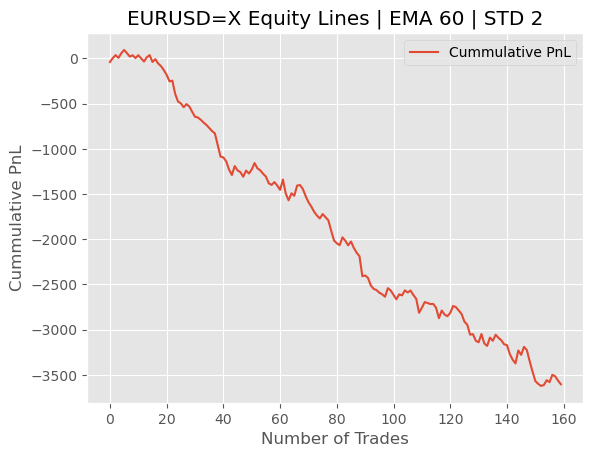

In [162]:
# Find the cummulative sum of the PnLs
backtest_pnl_bb = pd.DataFrame(stats_bb['_trades']["PnL"].copy())
backtest_pnl_bb["PnL CumSum"] = backtest_pnl_bb["PnL"].cumsum()

# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" Equity Lines | EMA "+str(init_ema_window)+" | STD "+str(init_std))
plt.plot(
    backtest_pnl_bb.index,
    backtest_pnl_bb["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**RSI Strategy**

In [163]:
bt_rsi = Backtest(insample_data, RSIStrategy, cash=10_000, commission=0.0024)
stats_rsi = bt_rsi.run(rsi_length = init_rsi_len, rsi_scalar = init_rsi_scalar)

In [164]:
# Get the backtest results
pnl_backtest_rsi = np.cumsum(stats_rsi['_trades'])
pnl_backtest_val_rsi = pnl_backtest_rsi['PnL'].iloc[-1]

backtest_results_table_rsi = [
    ["Start Date",stats_rsi['Start']],
    ["End Date",stats_rsi['End']],
    ["Peak Equity",stats_rsi['Equity Peak [$]']],
    ["Final Equity",stats_rsi['Equity Final [$]']],
    ["Sharpe Ratio",round(stats_rsi['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val_rsi, 3)}"],
    ["Return %", f"{round(stats_rsi['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_rsi['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats_rsi['_trades'])]
]

print(f"RSI Backesting results with investment of {10000} and commission of 0.24%\n")
print(tabulate(backtest_results_table_rsi, headers))    

RSI Backesting results with investment of 10000 and commission of 0.24%

Result            Value
----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10264.208823884106
Final Equity      5653.87186855776
Sharpe Ratio      0.0
PnL               $-4346.128
Return %          -43.461%
Win Rate [%]      23.196%
Number of trades  194


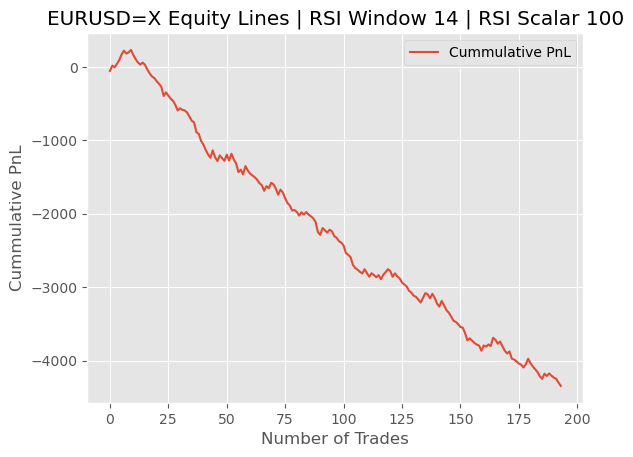

In [165]:
# Find the cummulative sum of the PnLs
backtest_pnl_rsi = pd.DataFrame(stats_rsi['_trades']["PnL"].copy())
backtest_pnl_rsi["PnL CumSum"] = backtest_pnl_rsi["PnL"].cumsum()

# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" Equity Lines | RSI Window "+str(init_rsi_len)+ " | RSI Scalar "+str(init_rsi_scalar))
plt.plot(
    backtest_pnl_rsi.index,
    backtest_pnl_rsi["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**Moving Average Convergence Divergence (MACD)**

In [166]:
bt_macd = Backtest(insample_data, MACDStrategy, cash=10_000, commission=0.0024)
stats_macd = bt_macd.run(macd_fast = init_fast, macd_slow = init_slow, macd_signal = init_signal)

In [167]:
# Get the backtest results
pnl_backtest_macd = np.cumsum(stats_macd['_trades'])
pnl_backtest_val_macd = pnl_backtest_macd['PnL'].iloc[-1]

backtest_results_table_macd = [
    ["Start Date",stats_macd['Start']],
    ["End Date",stats_macd['End']],
    ["Peak Equity",stats_macd['Equity Peak [$]']],
    ["Final Equity",stats_macd['Equity Final [$]']],
    ["Sharpe Ratio",round(stats_macd['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val_macd, 3)}"],
    ["Return %", f"{round(stats_macd['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_macd['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats_macd['_trades'])]
]

print(f"MACD Backesting results with investment of {10000} and commission of 0.24%\n")
print(tabulate(backtest_results_table_macd, headers))    

MACD Backesting results with investment of 10000 and commission of 0.24%

Result            Value
----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10004.118233729363
Final Equity      1989.309337071957
Sharpe Ratio      0.0
PnL               $-8010.691
Return %          -80.107%
Win Rate [%]      18.91%
Number of trades  624


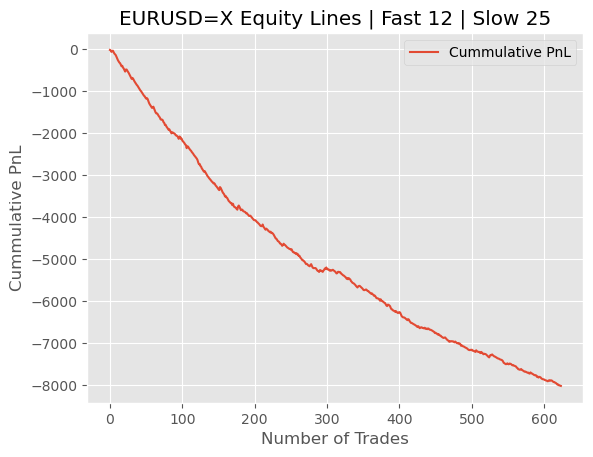

In [168]:
# Find the cummulative sum of the PnLs
backtest_pnl_macd = pd.DataFrame(stats_macd['_trades']["PnL"].copy())
backtest_pnl_macd["PnL CumSum"] = backtest_pnl_macd["PnL"].cumsum()

# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" Equity Lines | Fast "+str(init_fast)+ " | Slow "+str(init_slow))
plt.plot(
    backtest_pnl_macd.index,
    backtest_pnl_macd["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**Simple Moving Average (SMA) Crossover**

In [169]:
bt_sma = Backtest(insample_data, SMAStrategy, cash=10_000, commission=0.0024)
stats_sma = bt_sma.run(short = init_sma_short, long = init_sma_long)

In [170]:
# Get the backtest results
pnl_backtest_sma = np.cumsum(stats_sma['_trades'])
pnl_backtest_val_sma = pnl_backtest_sma['PnL'].iloc[-1]

backtest_results_table_sma = [
    ["Start Date",stats_sma['Start']],
    ["End Date",stats_sma['End']],
    ["Peak Equity",stats_sma['Equity Peak [$]']],
    ["Final Equity",stats_sma['Equity Final [$]']],
    ["Sharpe Ratio",round(stats_sma['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val_sma, 3)}"],
    ["Return %", f"{round(stats_sma['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_sma['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats_sma['_trades'])]
]

print(f"SMA Backesting results with investment of {10000} and commission of 0.24%\n")
print(tabulate(backtest_results_table_sma, headers))    

SMA Backesting results with investment of 10000 and commission of 0.24%

Result            Value
----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10000.0
Final Equity      9018.02921655096
Sharpe Ratio      0.0
PnL               $-981.971
Return %          -9.82%
Win Rate [%]      25.0%
Number of trades  76


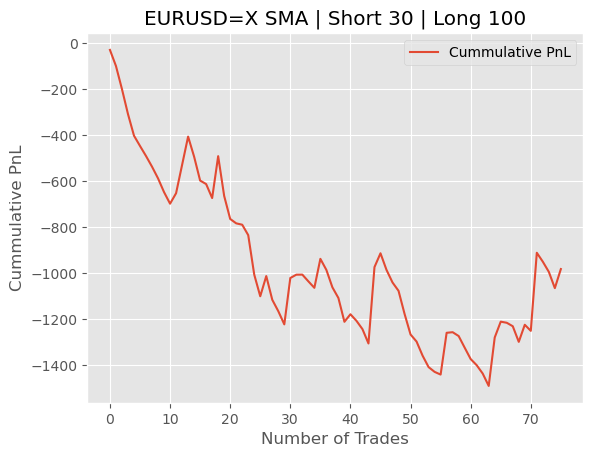

In [171]:
# Find the cummulative sum of the PnLs
backtest_pnl_sma = pd.DataFrame(stats_sma['_trades']["PnL"].copy())
backtest_pnl_sma["PnL CumSum"] = backtest_pnl_sma["PnL"].cumsum()

# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" SMA | Short "+str(init_sma_short) + " | Long "+str(init_sma_long))
plt.plot(
    backtest_pnl_sma.index,
    backtest_pnl_sma["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**Stochastic Oscillator**

In [172]:
bt_stoch = Backtest(insample_data, StochStrategy, cash=10_000, commission=0.0024)
stats_stoch = bt_stoch.run(fast = init_stoch_fast, slow = init_stoch_slow,
                           smooth=init_stoch_smooth, offset=init_stoch_offset)

In [173]:
# Get the backtest results
pnl_backtest_stoch = np.cumsum(stats_stoch['_trades'])
pnl_backtest_val_stoch = pnl_backtest_stoch['PnL'].iloc[-1]

backtest_results_table_stoch = [
    ["Start Date",stats_stoch['Start']],
    ["End Date",stats_stoch['End']],
    ["Peak Equity",stats_stoch['Equity Peak [$]']],
    ["Final Equity",stats_stoch['Equity Final [$]']],
    ["Sharpe Ratio",round(stats_stoch['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val_stoch, 3)}"],
    ["Return %", f"{round(stats_stoch['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_stoch['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats_stoch['_trades'])]
]

print(f"Stochastic Oscillator Backesting results with investment of {10000} and commission of 0.24%\n")
print(tabulate(backtest_results_table_stoch, headers))    

Stochastic Oscillator Backesting results with investment of 10000 and commission of 0.24%

Result            Value
----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       11489.206572299101
Final Equity      10357.437455777077
Sharpe Ratio      0.35368
PnL               $357.437
Return %          3.574%
Win Rate [%]      50.0%
Number of trades  8


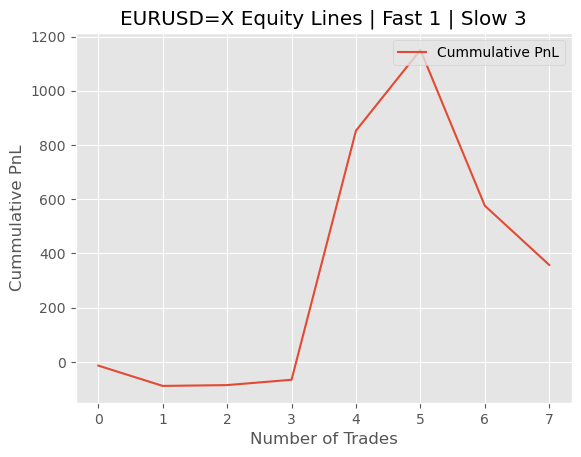

In [174]:
# Find the cummulative sum of the PnLs
backtest_pnl_stoch = pd.DataFrame(stats_stoch['_trades']["PnL"].copy())
backtest_pnl_stoch["PnL CumSum"] = backtest_pnl_stoch["PnL"].cumsum()

# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" Equity Lines | Fast "+str(init_stoch_fast)+" | Slow "+str(init_stoch_slow))
plt.plot(
    backtest_pnl_stoch.index,
    backtest_pnl_stoch["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 2.3 Optmizing and Cross-Validation

Run the backesting.py **optimize()** on the strategies above to select the best performing hyperparameters

**Bollinger Bands**

In [175]:
optimized_stats_bb, bb_heatmap = bt_bbands.optimize(
    ema_window = range(20, 71, 1),
    std = list(np.round(np.linspace(1, 3, 11), 1)),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm_bb = bb_heatmap.groupby(["ema_window", "std"]).mean().unstack()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

In [176]:
# Plot a second table with the optimized backtest results
pnl_optimized_bb = np.cumsum(optimized_stats_bb['_trades'])
pnl_optimized_val_bb = pnl_optimized_bb['PnL'].iloc[-1]

optimized_backtest_results_table_bb = [
    ["Start Date", optimized_stats_bb['Start']],
    ["End Date", optimized_stats_bb['End']],
    ["Peak Equity", optimized_stats_bb['Equity Peak [$]']],
    ["Final Equity",optimized_stats_bb['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats_bb['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val_bb,3)}"],
    ["Return %", f"{round(optimized_stats_bb['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats_bb['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats_bb['_trades'])]
]

print(f"Bollinger Bands Optimized Backesting Results\n")
print(tabulate(optimized_backtest_results_table_bb))                         

Bollinger Bands Optimized Backesting Results

----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10944.31382699768
Final Equity      10439.820269442676
Sharpe Ratio      0.41226
PnL               $439.82
Return %          4.398%
Win Rate [%]      41.86%
Number of trades  43
----------------  -------------------------


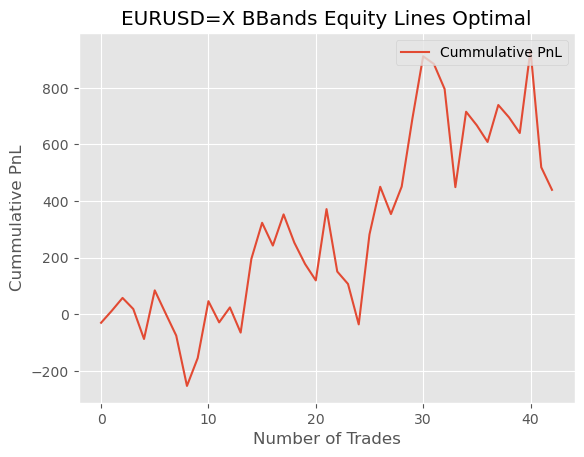

In [177]:
# Plot the close-to-close equity lines
validate_pnl_bb = pd.DataFrame(optimized_stats_bb['_trades']["PnL"].copy())
validate_pnl_bb["PnL CumSum"] = validate_pnl_bb["PnL"].cumsum()

# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" BBands Equity Lines Optimal")
plt.plot(
    validate_pnl_bb.index,
    validate_pnl_bb["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

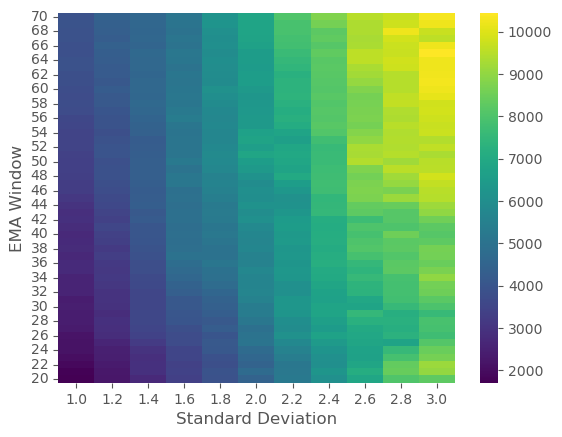

In [178]:
# Plot a heatmap of the best performing hyperparamters
pricing_hm_bb = sns.heatmap(hm_bb[::-1], cmap='viridis')
pricing_hm_bb.set(xlabel='Standard Deviation', ylabel='EMA Window')
plt.show()

In [179]:
# Get the optimal parameters
optimized_std_bb = optimized_stats_bb['_strategy'].std
optimized_window_bb = optimized_stats_bb['_strategy'].ema_window

print(f"Optimal standard deviation is {optimized_std_bb}")
print(f"Optimal EMA Window is {optimized_window_bb}")

Optimal standard deviation is 3.0
Optimal EMA Window is 65


In [216]:
# Run an instance of our Backtest class using  from section 2 using the 'outsample_dataset' from section 1.1
bt_optimal_bb = Backtest(outsample_data, BollingerBandsStrategy, cash=10_000, commission=0.0024)
stats_optimal_bb = bt_optimal_bb.run(ema_window = optimized_window_bb, std = optimized_std_bb)

pnl_rerun_bb = np.cumsum(stats_optimal_bb['_trades'])
pnl_rerun_val_bb = pnl_rerun_bb['PnL'].iloc[-1]

optimized_backtest_results_table_bb = [
    ["Start Date", stats_optimal_bb['Start']],
    ["End Date", stats_optimal_bb['End']],
    ["Peak Equity", stats_optimal_bb['Equity Peak [$]']],
    ["Final Equity",stats_optimal_bb['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal_bb['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val_bb,3)}"],
    ["Return %", f"{round(stats_optimal_bb['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal_bb['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal_bb['_trades'])]
]

print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table_bb, headers))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-12-05 00:00:00+00:00
End Date          2023-12-01 22:00:00+00:00
Peak Equity       10982.876085256585
Final Equity      9287.915450146686
Sharpe Ratio      0.0
PnL               $-712.085
Return %          -7.121%
Win Rate [%]      34.211%
Number of trades  38


In [ ]:
# Plot the cummulative PnL from the cross-validation
rerun_pnl_bb = pd.DataFrame(stats_optimal_bb['_trades']["PnL"].copy())
rerun_pnl_bb["PnL CumSum"] = rerun_pnl_bb["PnL"].cumsum()

plt.title(forex_pair+" BBands Equity Lines | EMA "+str(optimized_window_bb)+" | STD "+str(optimized_std_bb))
plt.plot(
    rerun_pnl_bb.index,
    rerun_pnl_bb["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**RSI**

In [219]:
optimized_stats_rsi, rsi_heatmap = bt_rsi.optimize(
    rsi_length = range(20, 71, 1),
    rsi_scalar = range(50,150, 10),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm_rsi = rsi_heatmap.groupby(["rsi_length", "rsi_scalar"]).mean().unstack()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

In [220]:
# Plot a second table with the optimized backtest results
pnl_optimized_rsi = np.cumsum(optimized_stats_rsi['_trades'])
pnl_optimized_val_rsi = pnl_optimized_rsi['PnL'].iloc[-1]

optimized_backtest_results_table_rsi = [
    ["Start Date", optimized_stats_rsi['Start']],
    ["End Date", optimized_stats_rsi['End']],
    ["Peak Equity", optimized_stats_rsi['Equity Peak [$]']],
    ["Final Equity",optimized_stats_rsi['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats_rsi['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val_rsi,3)}"],
    ["Return %", f"{round(optimized_stats_rsi['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats_rsi['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats_rsi['_trades'])]
]

print(f"RSI Optimized Backesting Results\n")
print(tabulate(optimized_backtest_results_table_rsi))                         

RSI Optimized Backesting Results

----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       11662.776385172574
Final Equity      11326.978769644467
Sharpe Ratio      1.16141
PnL               $1326.979
Return %          13.27%
Win Rate [%]      37.037%
Number of trades  27
----------------  -------------------------


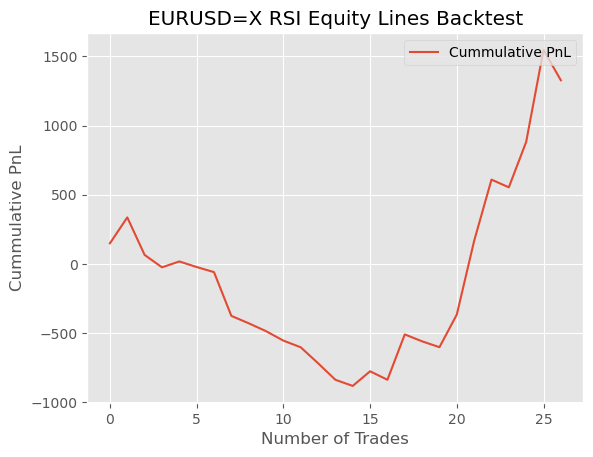

In [221]:
# Plot the close-to-close equity lines
validate_pnl_rsi = pd.DataFrame(optimized_stats_rsi['_trades']["PnL"].copy())
validate_pnl_rsi["PnL CumSum"] = validate_pnl_rsi["PnL"].cumsum()

# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" RSI Equity Lines Backtest")
plt.plot(
    validate_pnl_rsi.index,
    validate_pnl_rsi["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

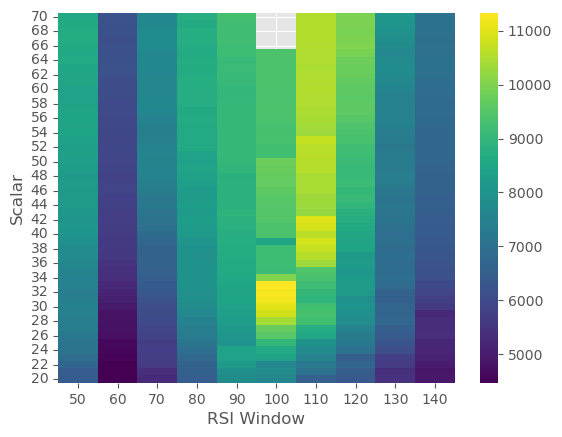

In [222]:
# Plot a heatmap of the best performing hyperparamters
pricing_hm_rsi = sns.heatmap(hm_rsi[::-1], cmap='viridis')
pricing_hm_rsi.set(xlabel='RSI Window', ylabel='Scalar')
plt.show()

In [223]:
# Get the optimal parameters
optimized_len_rsi = optimized_stats_rsi['_strategy'].rsi_length
optimized_scalar_rsi = optimized_stats_rsi['_strategy'].rsi_scalar

print(f"Optimal RSI Length is {optimized_len_rsi}")
print(f"Optimal RSI Scalar is {optimized_scalar_rsi}")

Optimal RSI Length is 33
Optimal RSI Scalar is 100


In [224]:
# Run an instance of our Backtest class using  from section 2 using the 'outsample_dataset' from section 1.1
bt_optimal_rsi = Backtest(outsample_data, RSIStrategy, cash=10_000, commission=0.0024)
stats_optimal_rsi = bt_optimal_rsi.run(rsi_length = optimized_len_rsi, rsi_scalar = optimized_scalar_rsi)

pnl_rerun_rsi = np.cumsum(stats_optimal_rsi['_trades'])
pnl_rerun_val_rsi = pnl_rerun_rsi['PnL'].iloc[-1]

optimized_backtest_results_table_rsi = [
    ["Start Date", stats_optimal_rsi['Start']],
    ["End Date", stats_optimal_rsi['End']],
    ["Peak Equity", stats_optimal_rsi['Equity Peak [$]']],
    ["Final Equity",stats_optimal_rsi['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal_rsi['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val_rsi,3)}"],
    ["Return %", f"{round(stats_optimal_rsi['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal_rsi['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal_rsi['_trades'])]
]

print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table_rsi, headers))                  

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-12-05 00:00:00+00:00
End Date          2023-12-01 22:00:00+00:00
Peak Equity       11051.097857368095
Final Equity      10588.181074396143
Sharpe Ratio      0.75864
PnL               $588.181
Return %          5.882%
Win Rate [%]      35.0%
Number of trades  20


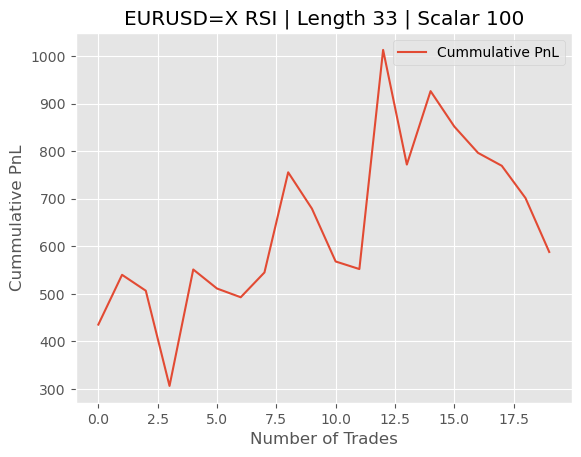

In [225]:
# Plot the cummulative PnL from the cross-validation
rerun_pnl_rsi = pd.DataFrame(stats_optimal_rsi['_trades']["PnL"].copy())
rerun_pnl_rsi["PnL CumSum"] = rerun_pnl_rsi["PnL"].cumsum()

plt.title(forex_pair+" RSI | Length "+str(optimized_len_rsi)+ " | Scalar "+str(optimized_scalar_rsi))
plt.plot(
    rerun_pnl_rsi.index,
    rerun_pnl_rsi["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**MACD**

In [228]:
optimized_stats_macd, macd_heatmap = bt_macd.optimize(
    macd_fast = range(10, 30, 2),
    macd_slow = range(10, 50, 2),
    macd_signal = range(5, 20, 1),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm_macd = macd_heatmap.groupby(["macd_fast", "macd_slow", "macd_signal"]).mean().unstack()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

In [229]:
# Plot a second table with the optimized backtest results
pnl_optimized_macd = np.cumsum(optimized_stats_macd['_trades'])
pnl_optimized_val_macd = pnl_optimized_macd['PnL'].iloc[-1]

optimized_backtest_results_table_macd = [
    ["Start Date", optimized_stats_macd['Start']],
    ["End Date", optimized_stats_macd['End']],
    ["Peak Equity", optimized_stats_macd['Equity Peak [$]']],
    ["Final Equity",optimized_stats_macd['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats_macd['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val_macd,3)}"],
    ["Return %", f"{round(optimized_stats_macd['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats_macd['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats_macd['_trades'])]
]

print(f"MACD Optimized Backesting Results\n")
print(tabulate(optimized_backtest_results_table_macd))                         

MACD Optimized Backesting Results

----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10020.00045399189
Final Equity      6093.658103212199
Sharpe Ratio      0.0
PnL               $-3906.342
Return %          -39.063%
Win Rate [%]      25.991%
Number of trades  227
----------------  -------------------------


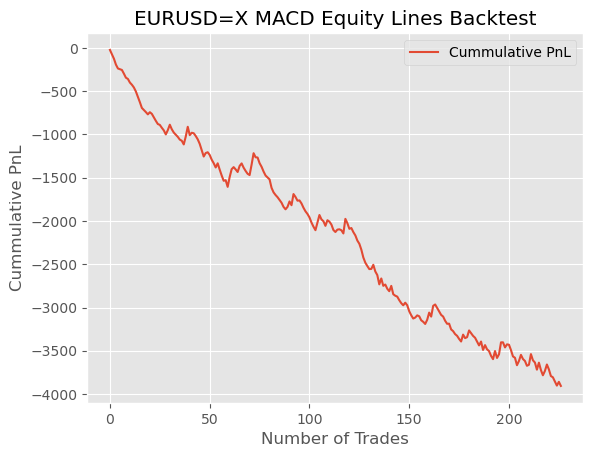

In [231]:
# Plot the close-to-close equity lines
validate_pnl_macd = pd.DataFrame(optimized_stats_macd['_trades']["PnL"].copy())
validate_pnl_macd["PnL CumSum"] = validate_pnl_macd["PnL"].cumsum()

# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" MACD Equity Lines Backtest")
plt.plot(
    validate_pnl_macd.index,
    validate_pnl_macd["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

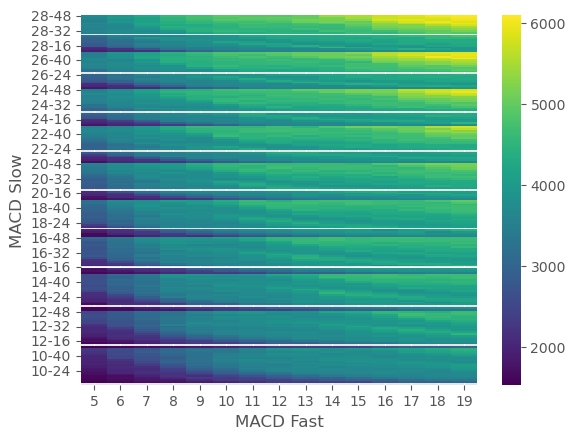

In [232]:
# Plot a heatmap of the best performing hyperparamters
pricing_hm_macd = sns.heatmap(hm_macd[::-1], cmap='viridis')
pricing_hm_macd.set(xlabel='MACD Fast', ylabel='MACD Slow')
plt.show()

In [233]:
# Get the optimal parameters
optimized_fast_macd = optimized_stats_macd['_strategy'].macd_fast
optimized_slow_macd = optimized_stats_macd['_strategy'].macd_slow
optimized_signal_macd = optimized_stats_macd['_strategy'].macd_signal

print(f"Optimal MACD fast is {optimized_fast_macd}")
print(f"Optimal MACD slow is {optimized_slow_macd}")
print(f"Optimal MACD signal is {optimized_signal_macd}")

Optimal MACD fast is 28
Optimal MACD slow is 48
Optimal MACD signal is 19


In [234]:
# Run an instance of our Backtest class using  from section 2 using the 'outsample_dataset' from section 1.1
bt_optimal_macd = Backtest(outsample_data, MACDStrategy, cash=10_000, commission=0.0024)
stats_optimal_macd = bt_optimal_macd.run(macd_fast = optimized_fast_macd, macd_slow = optimized_slow_macd,
                                    macd_signal = optimized_signal_macd)

pnl_rerun_macd = np.cumsum(stats_optimal_macd['_trades'])
pnl_rerun_val_macd = pnl_rerun_macd['PnL'].iloc[-1]

optimized_backtest_results_table_macd = [
    ["Start Date", stats_optimal_macd['Start']],
    ["End Date", stats_optimal_macd['End']],
    ["Peak Equity", stats_optimal_macd['Equity Peak [$]']],
    ["Final Equity",stats_optimal_macd['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal_macd['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val_macd,3)}"],
    ["Return %", f"{round(stats_optimal_macd['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal_macd['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal_macd['_trades'])]
]

print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table_macd, headers))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-12-05 00:00:00+00:00
End Date          2023-12-01 22:00:00+00:00
Peak Equity       10003.346322757721
Final Equity      6044.868107915185
Sharpe Ratio      0.0
PnL               $-3955.132
Return %          -39.551%
Win Rate [%]      23.223%
Number of trades  211


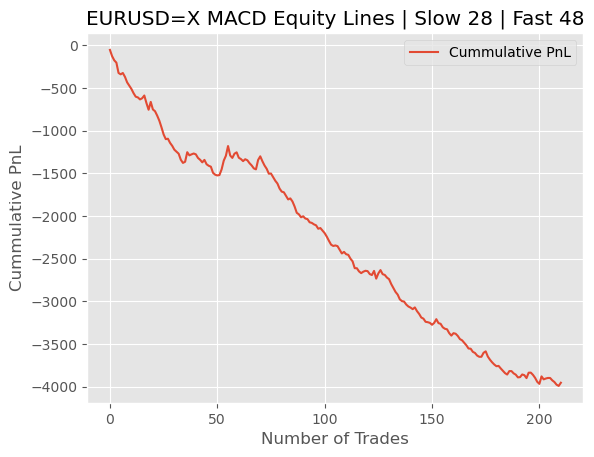

In [235]:
# Plot the cummulative PnL from the cross-validation
rerun_pnl_macd = pd.DataFrame(stats_optimal_macd['_trades']["PnL"].copy())
rerun_pnl_macd["PnL CumSum"] = rerun_pnl_macd["PnL"].cumsum()

plt.title(forex_pair+" MACD Equity Lines | Slow "+str(optimized_fast_macd)+" | Fast "+str(optimized_slow_macd))
plt.plot(
    rerun_pnl_macd.index,
    rerun_pnl_macd["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**SMA Crossover**

In [236]:
optimized_stats_sma, sma_heatmap = bt_sma.optimize(
    short = range(10, 50, 5),
    long = range(50,200, 5),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm_sma = sma_heatmap.groupby(["short", "long"]).mean().unstack()

  0%|          | 0/12 [00:00<?, ?it/s]

In [237]:
# Plot a second table with the optimized backtest results
pnl_optimized_sma = np.cumsum(optimized_stats_sma['_trades'])
pnl_optimized_val_sma = pnl_optimized_sma['PnL'].iloc[-1]

optimized_backtest_results_table_sma = [
    ["Start Date", optimized_stats_sma['Start']],
    ["End Date", optimized_stats_sma['End']],
    ["Peak Equity", optimized_stats_sma['Equity Peak [$]']],
    ["Final Equity",optimized_stats_sma['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats_sma['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val_sma,3)}"],
    ["Return %", f"{round(optimized_stats_sma['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats_sma['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats_sma['_trades'])]
]

print(f"SMA Optimized Backesting Results\n")
print(tabulate(optimized_backtest_results_table_sma))                         

SMA Optimized Backesting Results

----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       10058.678851888948
Final Equity      9946.692022114976
Sharpe Ratio      0.0
PnL               $-53.308
Return %          -0.533%
Win Rate [%]      28.049%
Number of trades  82
----------------  -------------------------


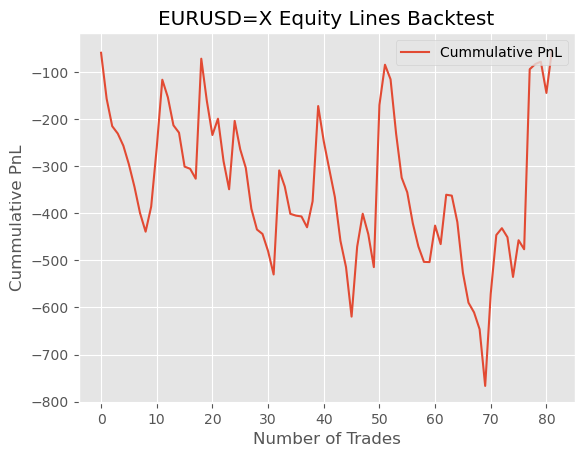

In [238]:
# Plot the close-to-close equity lines
validate_pnl_sma = pd.DataFrame(optimized_stats_sma['_trades']["PnL"].copy())
validate_pnl_sma["PnL CumSum"] = validate_pnl_sma["PnL"].cumsum()

# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" Equity Lines Backtest")
plt.plot(
    validate_pnl_sma.index,
    validate_pnl_sma["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

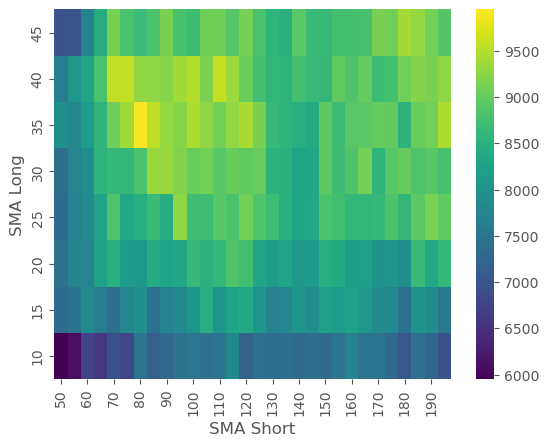

In [239]:
# Plot a heatmap of the best performing hyperparamters
pricing_hm_sma = sns.heatmap(hm_sma[::-1], cmap='viridis')
pricing_hm_sma.set(xlabel='SMA Short', ylabel='SMA Long')
plt.show()

In [240]:
# Get the optimal parameters
optimized_short_sma = optimized_stats_sma['_strategy'].short
optimized_long_sma = optimized_stats_sma['_strategy'].long

print(f"Optimal SMA Short is {optimized_short_sma}")
print(f"Optimal SMA Long is {optimized_long_sma}")

Optimal SMA Short is 35
Optimal SMA Long is 80


In [241]:
# Run an instance of our Backtest class using  from section 2 using the 'outsample_dataset' from section 1.1
bt_optimal_sma = Backtest(outsample_data, SMAStrategy, cash=10_000, commission=0.0024)
stats_optimal_sma = bt_optimal_sma.run(short = optimized_short_sma, long = optimized_long_sma)

pnl_rerun_sma = np.cumsum(stats_optimal_sma['_trades'])
pnl_rerun_val_sma = pnl_rerun_sma['PnL'].iloc[-1]

optimized_backtest_results_table_sma = [
    ["Start Date", stats_optimal_sma['Start']],
    ["End Date", stats_optimal_sma['End']],
    ["Peak Equity", stats_optimal_sma['Equity Peak [$]']],
    ["Final Equity",stats_optimal_sma['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal_sma['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val_sma,3)}"],
    ["Return %", f"{round(stats_optimal_sma['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal_sma['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal_sma['_trades'])]
]

print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table_sma, headers))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-12-05 00:00:00+00:00
End Date          2023-12-01 22:00:00+00:00
Peak Equity       10014.065880002212
Final Equity      7187.209823538237
Sharpe Ratio      0.0
PnL               $-2812.79
Return %          -28.128%
Win Rate [%]      23.333%
Number of trades  90


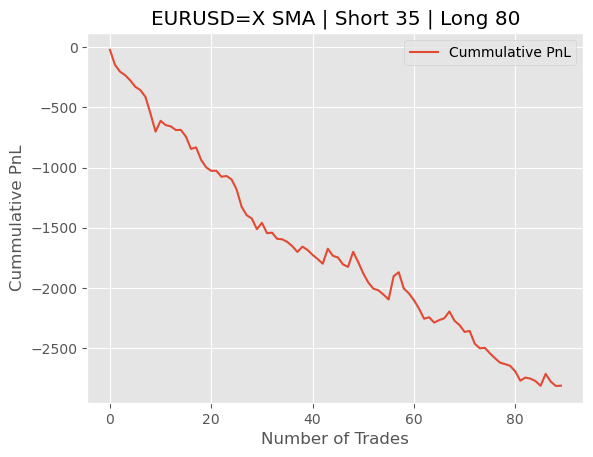

In [242]:
# Plot the cummulative PnL from the cross-validation
rerun_pnl_sma = pd.DataFrame(stats_optimal_sma['_trades']["PnL"].copy())
rerun_pnl_sma["PnL CumSum"] = rerun_pnl_sma["PnL"].cumsum()

plt.title(forex_pair+" SMA | Short "+str(optimized_short_sma) + " | Long "+str(optimized_long_sma))
plt.plot(
    rerun_pnl_sma.index,
    rerun_pnl_sma["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

**Stochastic Oscillator**

In [244]:
optimized_stats_stoch, stoch_heatmap = bt_stoch.optimize(
    fast = 1,
    slow = range(1, 3, 1),
    smooth = range(1, 3, 1),
    offset = list(np.round(np.linspace(0, 2, 11), 1)),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm_stoch = stoch_heatmap.groupby(["fast", "slow", "smooth", "offset"]).mean().unstack()

  0%|          | 0/15 [00:00<?, ?it/s]

In [245]:
# Plot a second table with the optimized backtest results
pnl_optimized_stoch = np.cumsum(optimized_stats_stoch['_trades'])
pnl_optimized_val_stoch = pnl_optimized_stoch['PnL'].iloc[-1]

optimized_backtest_results_table_stoch = [
    ["Start Date", optimized_stats_stoch['Start']],
    ["End Date", optimized_stats_stoch['End']],
    ["Peak Equity", optimized_stats_stoch['Equity Peak [$]']],
    ["Final Equity",optimized_stats_stoch['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats_stoch['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val_stoch,3)}"],
    ["Return %", f"{round(optimized_stats_stoch['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats_stoch['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats_stoch['_trades'])]
]

print(f"Stochastic Oscillator Optimized Backesting Results\n")
print(tabulate(optimized_backtest_results_table_stoch))                         

Stochastic Oscillator Optimized Backesting Results

----------------  -------------------------
Start Date        2021-12-06 00:00:00+00:00
End Date          2022-12-02 22:00:00+00:00
Peak Equity       11214.717336701891
Final Equity      9954.403920264222
Sharpe Ratio      0.0
PnL               $-45.596
Return %          -0.456%
Win Rate [%]      47.5%
Number of trades  40
----------------  -------------------------


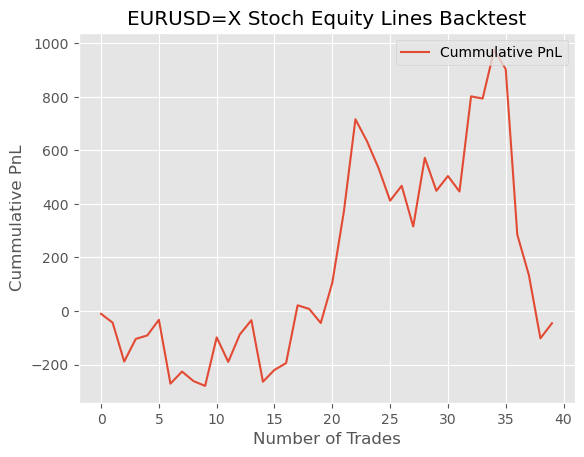

In [246]:
# Plot the close-to-close equity lines
validate_pnl_stoch = pd.DataFrame(optimized_stats_stoch['_trades']["PnL"].copy())
validate_pnl_stoch["PnL CumSum"] = validate_pnl_stoch["PnL"].cumsum()

# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" Stoch Equity Lines Backtest")
plt.plot(
    validate_pnl_stoch.index,
    validate_pnl_stoch["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

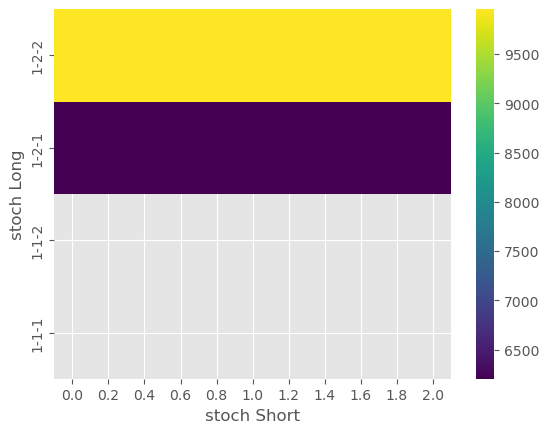

In [247]:
# Plot a heatmap of the best performing hyperparamters
pricing_hm_stoch = sns.heatmap(hm_stoch[::-1], cmap='viridis')
pricing_hm_stoch.set(xlabel='stoch Short', ylabel='stoch Long')
plt.show()

In [248]:
# Get the optimal parameters
optimized_fast_stoch = optimized_stats_stoch['_strategy'].fast
optimized_slow_stoch = optimized_stats_stoch['_strategy'].slow
optimized_smooth_stoch = optimized_stats_stoch['_strategy'].smooth
optimized_offset_stoch = optimized_stats_stoch['_strategy'].offset
    
print(f"Optimal fast is {optimized_fast_stoch}")
print(f"Optimal slow is {optimized_slow_stoch}")
print(f"Optimal smooth is {optimized_smooth_stoch}")
print(f"Optimal offset is {optimized_offset_stoch}")

Optimal fast is 1
Optimal slow is 2
Optimal smooth is 2
Optimal offset is 0.0


In [249]:
# Run an instance of our Backtest class using  from section 2 using the 'outsample_dataset' from section 1.1
bt_optimal_stoch = Backtest(outsample_data, StochStrategy, cash=10_000, commission=0.0024)
stats_optimal_stoch = bt_optimal_stoch.run(fast = optimized_fast_stoch, slow = optimized_slow_stoch,
                           smooth=optimized_smooth_stoch, offset=optimized_offset_stoch)

pnl_rerun_stoch = np.cumsum(stats_optimal_stoch['_trades'])
pnl_rerun_val_stoch = pnl_rerun_stoch['PnL'].iloc[-1]

optimized_backtest_results_table_stoch = [
    ["Start Date", stats_optimal_stoch['Start']],
    ["End Date", stats_optimal_stoch['End']],
    ["Peak Equity", stats_optimal_stoch['Equity Peak [$]']],
    ["Final Equity",stats_optimal_stoch['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal_stoch['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val_stoch,3)}"],
    ["Return %", f"{round(stats_optimal_stoch['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal_stoch['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal_stoch['_trades'])]
]

print(f"Backesting optimized results with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table_stoch, headers))                         

Backesting optimized results with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-12-05 00:00:00+00:00
End Date          2023-12-01 22:00:00+00:00
Peak Equity       10005.279791479494
Final Equity      9227.887282471575
Sharpe Ratio      0.0
PnL               $-772.113
Return %          -7.721%
Win Rate [%]      45.833%
Number of trades  24


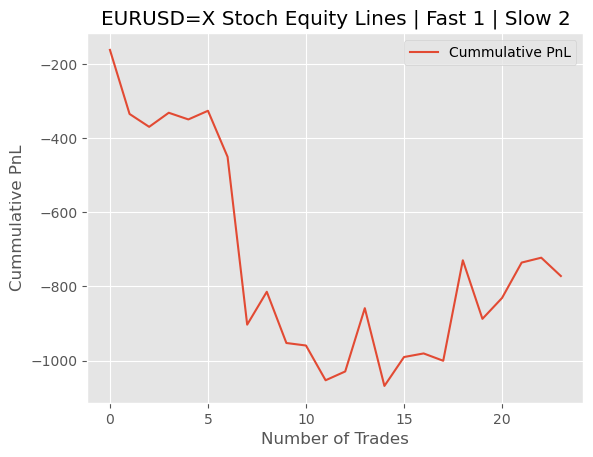

In [250]:
# Plot the cummulative PnL from the cross-validation
rerun_pnl_stoch = pd.DataFrame(stats_optimal_stoch['_trades']["PnL"].copy())
rerun_pnl_stoch["PnL CumSum"] = rerun_pnl_stoch["PnL"].cumsum()

plt.title(forex_pair+" Stoch Equity Lines | Fast "+str(optimized_fast_stoch)+" | Slow "+str(optimized_slow_stoch))
plt.plot(
    rerun_pnl_stoch.index,
    rerun_pnl_stoch["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 3. Backtesting, Cross-Validation and Saving Metrics for more currency pairs

Create a list of the currency pairs to test, excluding EUR/USD

In [ ]:
currency_pairs = ['USDJPY=X',
                  'GBPUSD=X',
                  'AUDUSD=X',
                  'USDCAD=X',
                  'USDCHF=X',
                  'EURGBP=X',
                  'EURJPY=X',
                  'GBPJPY=X',
                  'EURCHF=X',
                  'USDNOK=X',
                  'USDCNY=X',
                  'EURCAD=X',
                  'USDHKD=X',
                  'USDSGD=X',
                  'USDKRW=X',
                  'USDSGD=X',
                  'EURAUD=X',
                  'EURNZD=X',
                  'GBPCHF=X']

Create the direcories insample and outsample to hold the insample and outsample data

In [67]:
insample_dir = 'insample'
if not os.path.exists(insample_dir):
    os.mkdir(insample_dir)
    
outsample_dir = 'outsample'
if not os.path.exists(outsample_dir):
    os.mkdir(outsample_dir)

Download the data from the API for each and save it into a csv file

In [685]:
for forex_pair in currency_pairs:
    
    data = yf.download(forex_pair, interval = interval, start = start_date)

    # Slice the downloaded two-year data into two datasets
    fx_insample_data = pd.DataFrame(data.loc[last_729_days_date : slice_one_end_date].copy())
    fx_outsample_data = pd.DataFrame(data.loc[slice_two_start_date:today].copy())
    
    insample_filename = "insample_"+forex_pair+".csv"
    outsample_filename = "outsample_"+forex_pair+".csv"
    
    # Save the CSV files to their respective directories
    fx_insample_data.to_csv("insample/"+insample_filename)
    fx_outsample_data.to_csv("outsample/"+outsample_filename)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### 3.1 Backtest and save historical data

Define functions that will run the backtests for the currency pair list above using the strategies created above. Backtest the 19 currency pairs with the strategies, using the saved historical data for 2021 to 2023 in the directory insample data

Create the direcories backtest and crossvalidate to hold the currency backtest and cross-validation metrics

In [691]:
backtest_dir = 'backtest'
if not os.path.exists(backtest_dir):
    os.mkdir(backtest_dir)
    
crossvalidate_dir = 'crossvalidate'
if not os.path.exists(crossvalidate_dir):
    os.mkdir(crossvalidate_dir)

**Bollinger Bands**

In [687]:
def backtest_bb_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting BollingerBandsStrategy strategy on the currency pair data in the insample directory
    using the initial parameters defined

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(ema_window=init_ema_window, std=init_std)

            optimized_stats = bt.optimize(
                ema_window=range(20, 71, 1),
                std=list(np.round(np.linspace(1, 3, 11), 1)),
                maximize='Equity Final [$]',
                return_heatmap=False
            )
            
            optmized_std = optimized_stats['_strategy'].std
            optimized_window = optimized_stats['_strategy'].ema_window
            
            insample_file_data.append(list([symbol, stats, optmized_std, optimized_window]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [688]:
bulk_backtest_results_bb = backtest_bb_strategy(10_000, 0.0024)

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

In [692]:
# Save the backtest metrics into a list and write the data into a csv file

backtest_header_bb = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal STD", "Optimal EMA"]

backtest_metrics_bb = []

for result in bulk_backtest_results_bb:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics_bb.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))

# Write the data to the file backtest_metrics.csv
with open('backtest/backtest_metrics_bollinger_bands.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header_bb)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics_bb)

**RSI**

In [253]:
def backtest_rsi_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting RSIStrategy strategy on the currency pair data in the insample directory
    uusing the initial parameters defined

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, RSIStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(rsi_length = init_rsi_len, rsi_scalar = init_rsi_scalar)

            optimized_stats = bt.optimize(
                 rsi_length = range(20, 71, 1),
                 rsi_scalar = range(50,150, 10),
                 maximize = 'Equity Final [$]',
                 return_heatmap = False
            )
            
            optmized_length = optimized_stats['_strategy'].rsi_length
            optimized_scalar = optimized_stats['_strategy'].rsi_scalar
            
            insample_file_data.append(list([symbol, stats, optmized_length, optimized_scalar]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [254]:
bulk_backtest_results_rsi = backtest_rsi_strategy(10_000, 0.0024)

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 510 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

In [696]:
# Save the backtest metrics into a list and write the data into a csv file
backtest_header_rsi = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal Length", "Optimal Scalar"]

backtest_metrics_rsi = []

for result in bulk_backtest_results_rsi:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics_rsi.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))

# Write the data to the file backtest_metrics.csv
with open('backtest/backtest_metrics_rsi.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header_rsi)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics_rsi)

**MACD**

In [203]:
def backtest_macd_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting MACDStrategy strategy on the currency pair data in the insample directory
    using the initial parameters defined

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, MACDStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(macd_fast = init_fast, macd_slow = init_slow, macd_signal = init_signal)

            optimized_stats = bt.optimize(
                 macd_fast = range(10, 30, 2),
                 macd_slow = range(10, 50, 2),
                 macd_signal = range(5, 20, 1),
                 maximize = 'Equity Final [$]',
                 return_heatmap = False
            )
            
            optmized_fast = optimized_stats['_strategy'].macd_fast
            optimized_slow = optimized_stats['_strategy'].macd_slow
            optimized_signal = optimized_stats['_strategy'].macd_signal
            
            insample_file_data.append(list([symbol, stats, optmized_fast, optimized_slow, optimized_signal]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [204]:
bulk_backtest_results_macd = backtest_macd_strategy(10_000, 0.0024)

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 3000 configurations.
  output = _optimize_grid()


  0%|          | 0/12 [00:00<?, ?it/s]

In [206]:
# Save the backtest metrics into a list and write the data into a csv file
backtest_header_macd = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal Fast", "Optimal Slow", "Optimal Signal"]

backtest_metrics_macd = []

for result in bulk_backtest_results_macd:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics_macd.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))

# Write the data to the file backtest_metrics.csv
with open('backtest/backtest_metrics_macd.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header_macd)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics_macd)

**Simple Moving Average Crossover**

In [704]:
def backtest_sma_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting SMAStrategy strategy on the currency pair data in the insample directory
    using the initial parameters defined

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, SMAStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(short = init_sma_short, long = init_sma_long)

            optimized_stats = bt.optimize(
                 short = range(10, 50, 5),
                 long = range(50,200, 5),
                 maximize = 'Equity Final [$]',
                 return_heatmap = False
            )
            
            optmized_short = optimized_stats['_strategy'].short
            optimized_long = optimized_stats['_strategy'].long
            
            insample_file_data.append(list([symbol, stats, optmized_short, optimized_long]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [705]:
bulk_backtest_results_sma = backtest_sma_strategy(10_000, 0.0024)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [707]:
# Save the backtest metrics into a list and write the data into a csv file
backtest_header_sma = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal Short", "Optimal Long"]

backtest_metrics_sma = []

for result in bulk_backtest_results_sma:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics_sma.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))

# Write the data to the file backtest_metrics.csv
with open('backtest/backtest_metrics_sma.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header_sma)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics_sma)

**Stochastic Oscillator**

In [712]:
def backtest_stoch_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting StochStrategy strategy on the currency pair data in the insample directory
    using the initial parameters defined

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, StochStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(fast = init_stoch_fast, slow = init_stoch_slow,
                           smooth=init_stoch_smooth, offset=init_stoch_offset)

            optimized_stats = bt.optimize(
                 fast = 1,
                 slow = range(1, 3, 1),
                 smooth = range(1, 3, 1),
                 offset = list(np.round(np.linspace(0, 2, 11), 1)),
                 maximize = 'Equity Final [$]',
                 return_heatmap = False
            )
            
            optmized_fast = optimized_stats['_strategy'].fast
            optimized_slow = optimized_stats['_strategy'].slow
            optimized_smooth = optimized_stats['_strategy'].smooth
            optimized_offset = optimized_stats['_strategy'].offset
            
            insample_file_data.append(list([symbol, stats, optmized_fast, optimized_slow, optimized_smooth, optimized_offset]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [713]:
bulk_backtest_results_stoch = backtest_stoch_strategy(10_000, 0.0024)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [714]:
# Save the backtest metrics into a list and write the data into a csv file

backtest_header_stoch = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal Fast", "Optimal Slow", "Optimal Smooth", "Optimal Offset"]

backtest_metrics_stoch = []

for result in bulk_backtest_results_stoch:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics_stoch.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))

# Write the data to the file backtest_metrics.csv
with open('backtest/backtest_metrics_stoch.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header_stoch)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics_stoch)

### 3.2 Cross-validate and save cross-validation data

Define the functions that will run the backtests for the currency pair list above using the strategies created. Backtest the 19 currency pairs with the optimized bollinger bands strategy, using the saved data for 2021 to 2023 in the directory outsample/

**Bollinger Bands**

In [68]:
insample_file_data_bb = []

def validate_bb_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting BollingerBandsStrategy strategy on the currency pair data
    in the outsample directory. The paramters used for each currency pair dataset are selected from
    the backtest optimization results

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal params from the backtest metrics file
            metrics_data = pd.read_csv('backtest/backtest_metrics_bollinger_bands.csv')
            optimal_ema = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal EMA"][index]
            optimal_std = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal STD"][index]
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(ema_window=optimal_ema, std=optimal_std)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [70]:
bulk_validate_results_bb = validate_bb_strategy(10_000, 0.0024)

In [73]:
# Save the validation metrics into a list and write the data into a csv file

validate_metrics_bb = []
for result in bulk_validate_results_bb:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics_bb.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN']
    ]))

In [74]:
validation_header = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN"]

In [76]:
# Write the data to the file validation_metrics.csv
with open('crossvalidate/validation_metrics_bollinger_bands.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics_bb)

**RSI**

In [95]:
insample_file_data_rsi = []

def validate_rsi_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting RSIBandsStrategy strategy on the currency pair data
    in the outsample directory. The paramters used for each currency pair dataset are selected from
    the backtest optimization results

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal params from the backtest metrics file
            metrics_data = pd.read_csv('backtest/backtest_metrics_rsi.csv')
            optimal_length = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Length"][index]
            optimal_scalar = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Scalar"][index]
            
            bt = Backtest(data_df, RSIStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(rsi_length=optimal_length, rsi_scalar=optimal_scalar)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [96]:
bulk_validate_results_rsi = validate_rsi_strategy(10_000, 0.0024)

In [97]:
# Save the validation metrics into a list and write the data into a csv file

validate_metrics_rsi = []
for result in bulk_validate_results_rsi:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics_rsi.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN']
    ]))

In [98]:
# Write the data to the file validation_metrics.csv
with open('crossvalidate/validation_metrics_rsi.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics_rsi)

**MACD**

In [207]:
insample_file_data_macd = []

def validate_macd_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting MACDBandsStrategy strategy on the currency pair data
    in the outsample directory. The paramters used for each currency pair dataset are selected from
    the backtest optimization results

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal params from the backtest metrics file
            metrics_data = pd.read_csv('backtest/backtest_metrics_macd.csv')
            optimal_fast = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Fast"][index]
            optimal_slow = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Slow"][index]
            optimal_signal = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Signal"][index]
            
            bt = Backtest(data_df, MACDStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(macd_fast = optimal_fast, macd_slow = optimal_slow, macd_signal = optimal_signal)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [208]:
bulk_validate_results_macd = validate_macd_strategy(10_000, 0.0024)

In [209]:
# Save the validation metrics into a list and write the data into a csv file

validate_metrics_macd = []
for result in bulk_validate_results_macd:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics_macd.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN']
    ]))

In [211]:
# Write the data to the file validation_metrics.csv
with open('crossvalidate/validation_metrics_macd.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics_macd)

**SMA Crossover**

In [185]:
insample_file_data_sma = []

def validate_sma_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting SMAStrategy strategy on the currency pair data
    in the outsample directory. The paramters used for each currency pair dataset are selected from
    the backtest optimization results

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal params from the backtest metrics file
            metrics_data = pd.read_csv('backtest/backtest_metrics_sma.csv')
            optimal_short = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Short"][index]
            optimal_long = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Long"][index]
            
            bt = Backtest(data_df, SMAStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(short = optimal_short, long = optimal_long)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [186]:
bulk_validate_results_sma = validate_sma_strategy(10_000, 0.0024)

In [191]:
# Save the validation metrics into a list and write the data into a csv file

validate_metrics_sma = []
for result in bulk_validate_results_sma:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics_sma.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN']
    ]))

In [192]:
# Write the data to the file validation_metrics.csv
with open('crossvalidate/validation_metrics_sma.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics_sma)

**Stochastic Oscillator**

In [199]:
insample_file_data_stoch = []

def validate_stoch_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting StochStrategy strategy on the currency pair data
    in the outsample directory. The paramters used for each currency pair dataset are selected from
    the backtest optimization results

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal params from the backtest metrics file
            metrics_data = pd.read_csv('backtest/backtest_metrics_stoch.csv')
            optimal_fast = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Fast"][index]
            optimal_slow = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Slow"][index]
            optimal_smooth = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Smooth"][index]
            optimal_offset = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal Offset"][index]
            
            bt = Backtest(data_df, StochStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(fast = optimal_fast, slow = optimal_slow,
                           smooth=optimal_smooth, offset=optimal_offset)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [200]:
bulk_validate_results_stoch = validate_stoch_strategy(10_000, 0.0024)

In [201]:
# Save the validation metrics into a list and write the data into a csv file

validate_metrics_stoch = []
for result in bulk_validate_results_stoch:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics_stoch.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN']
    ]))

In [202]:
# Write the data to the file validation_metrics.csv
with open('crossvalidate/validation_metrics_stoch.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics_stoch)

## 4. Unit Testing

Define a class TestSuite that tests different scenarios for our backtests

In [ ]:
class TestSuite(unittest.TestCase):
    def test_data_loading(self):
        # Test that the data loading function correctly loads and processes the data
        price_data = yf.download(forex_pair, interval = interval, start = start_date)

        # Assert that the loaded data is not empty
        self.assertFalse(price_data.empty)

    def test_valid_currency_pair(self):
        # Test that the data loading function only accepts valid currency pairs
        price_data = yf.download("XYZ", interval = interval, start = start_date)

        # Assert that the loaded data is not empty
        self.assertTrue(price_data.empty)
        
    def test_backtest_amount(self):
        cash =  10000
        bt = Backtest(insample_data, BollingerBandsStrategy, cash=cash, commission=0.0024)
        stats = bt.run(ema_window = init_ema_window, std = init_std)
        
        # Assert that the statistics generated are valid
        self.assertNotEqual(cash, 0)

Create a test suite and run the tests

In [ ]:
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestSuite)
unittest.TextTestRunner(verbosity=2).run(test_suite)